# Апробация модели мультиэкспоненциального частотного скана на данных из набора "1564ЛЕ1 при разных U1 Ur август 2022"

## 0. Импорт модулей

In [1]:
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from fsmodels import SklMultiExpFrequencyScan, SklSingleExpFrequencyScan

from fsplots import plot_experimental_points
from fsplots import plot_spectr
from fsplots import plot_model
from fsplots import plot_loss_path
from fsplots import plot_deviations

%matplotlib inline

## 1. Чтение данных

In [2]:
DATASET_PATH = '../dataset/'
PLOTS_PATH = '../plots/'
MODELS_PATH = '../models/'

In [3]:
file_names = listdir(DATASET_PATH)

In [4]:
u1 = -4
ur = -5

data_frames = [[file_name, pd.read_csv(DATASET_PATH + file_name, parse_dates=[0])] for file_name in file_names]

condition = lambda frame: frame.loc[0, 'u1']==u1 and frame.loc[0, 'ur']==ur
data_frames = [[name, frame] for [name, frame] in data_frames if condition(frame)]

In [5]:
len(data_frames)

3

In [6]:
print(data_frames[0][0])
data_frames[0][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-03 14:34:48,2500.0000,1.456,303.264,0.007280,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-03 14:34:52,1985.8207,1.526,303.276,0.007630,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-03 14:34:56,1577.3937,1.649,303.279,0.008245,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-03 14:35:00,1252.9686,1.755,303.281,0.008775,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-03 14:35:03,995.2686,1.907,303.281,0.009535,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


In [7]:
data_frames[0][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               34 non-null     datetime64[ns]
 1   frequency_hz       34 non-null     float64       
 2   dlts_v             34 non-null     float64       
 3   temperature_k      34 non-null     float64       
 4   dlts_pf            34 non-null     float64       
 5   bs                 34 non-null     int64         
 6   ls                 34 non-null     int64         
 7   f_pulse            34 non-null     float64       
 8   u1                 34 non-null     float64       
 9   ur                 34 non-null     float64       
 10  time_between_meas  34 non-null     float64       
 11  integral_time      34 non-null     float64       
 12  specimen_name      34 non-null     object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage:

In [8]:
print(data_frames[1][0])
data_frames[1][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-04 15:21:09,2500.0000,3.122,283.194,0.001561,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-04 15:21:13,2443.0925,3.187,283.187,0.001593,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-04 15:21:17,2387.4812,3.201,283.191,0.001600,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-04 15:21:21,2333.1355,3.259,283.206,0.001629,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-04 15:21:25,2280.0269,3.271,283.199,0.001636,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


In [9]:
data_frames[1][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

In [10]:
print(data_frames[2][0])
data_frames[2][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-02 17:55:01,2500.0000,5.276,262.940,0.000528,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-02 17:55:05,2443.0925,5.449,262.941,0.000545,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-02 17:55:09,2387.4812,5.855,262.941,0.000585,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-02 17:55:13,2333.1355,6.665,262.940,0.000666,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-02 17:55:17,2280.0269,6.626,262.936,0.000663,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


In [11]:
data_frames[2][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

## 2. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_10пФ\_+30С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,1.csv
### 2.1. Подготовка экспериментальных данных

In [12]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    X_train = np.log10(dataset.frequency_hz.to_numpy())
    y_train = dataset.dlts_pf.to_numpy()
    
    return filling_pulse, X_train, y_train

In [13]:
filling_pulse, X_train, y_train = get_X_y(data_frames[0][1])

In [14]:
normalize = lambda X, y: (X.max() / y.max(), y * X.max() / y.max())
denormalize = lambda X, y_normalized: y_normalized * y_normalized.max() / X.max()

In [15]:
k, y_train = normalize(X_train, y_train)
k

180.3577499295137

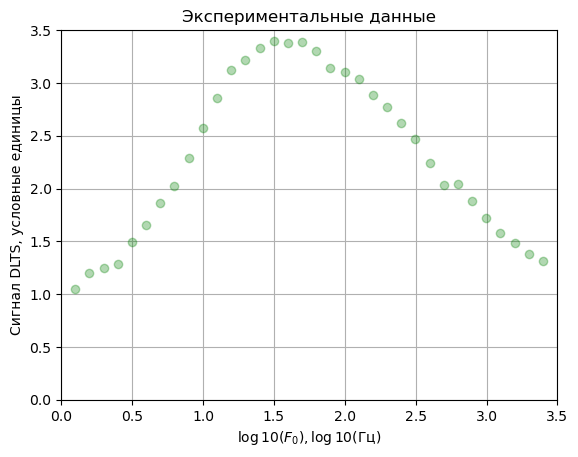

In [16]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_ylim([0, 3.5])
ax.set_xlim([0, 3.5])
plt.show()

### 2.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [17]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)
monoexp_fs.fit_results_

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
0,-0.179791,0.00001,True,0.05,6.146197,1,1000,1.000000,0.00001,-3.167167,False
1,-0.110193,0.00001,True,0.05,6.048700,1,1000,1.005253,0.00001,-3.178218,False
2,-0.043093,0.00001,True,0.05,5.959311,1,1000,1.008381,0.00001,-3.184956,False
3,0.021907,0.00001,True,0.05,5.875902,1,1000,1.009578,0.00001,-3.187578,False
4,0.085167,0.00001,True,0.05,5.796659,1,1000,1.008979,0.00001,-3.186252,False
...,...,...,...,...,...,...,...,...,...,...,...
167,3.337396,0.00001,True,0.05,0.014214,1,1000,0.275240,0.00001,-1.920391,False
168,3.338141,0.00001,True,0.05,0.014203,1,1000,0.275366,0.00001,-1.920368,False
169,3.338866,0.00001,True,0.05,0.014192,1,1000,0.275488,0.00001,-1.920345,False
170,3.339570,0.00001,True,0.05,0.014182,1,1000,0.275607,0.00001,-1.920323,False


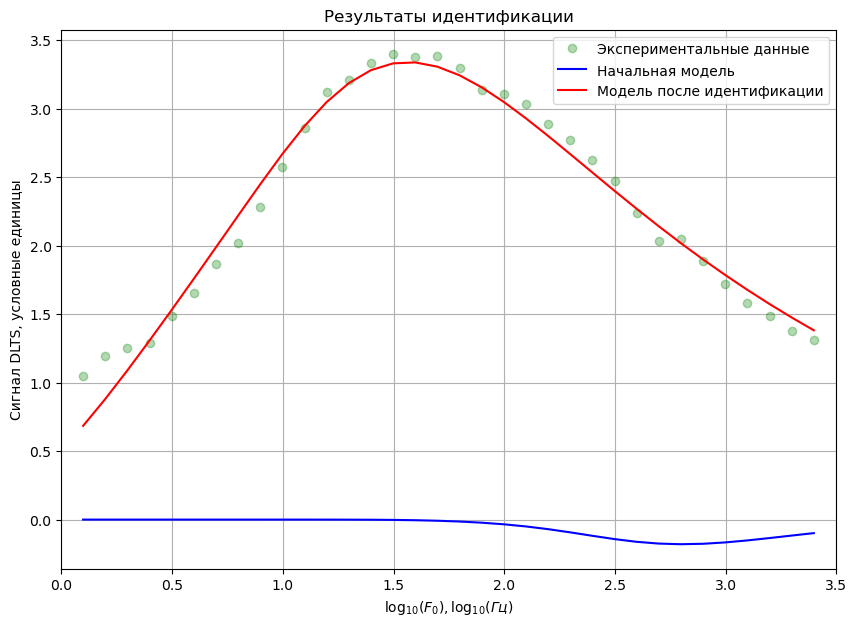

In [18]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, monoexp_fs.fit_results_, plot_exps=False)
plt.show()

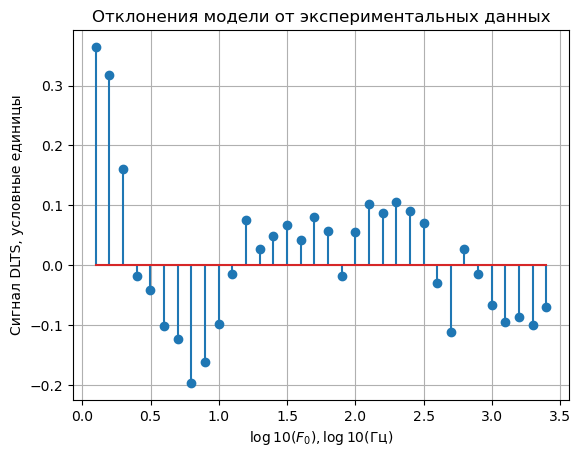

In [19]:
plot_deviations(X_train, y_train, monoexp_fs.predict(X_train))
plt.show()

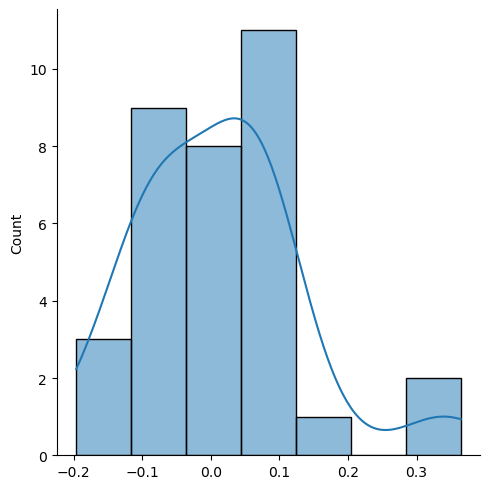

In [20]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

In [21]:
mean_squared_error(y_train, y_train - monoexp_fs.predict(X_train), squared=False)

2.417660790666946

### 2.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [22]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       stop_val = 10**-5,
                                       learning_rate=0.05,
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                         learning_rate=0.05, stop_val=1e-05)

In [23]:
multiexp_fs.fit_results_

,amplitude_0,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,verbose
0,-0.357747,0.00001,0.05,6.751985,1,1000,0.00001,-1.832394,False
1,-0.234465,0.00001,0.05,6.451887,1,1000,0.00001,-1.829134,False
2,-0.114471,0.00001,0.05,6.167675,1,1000,0.00001,-1.826921,False
3,0.002329,0.00001,0.05,5.898434,1,1000,0.00001,-1.825815,False
4,0.116032,0.00001,0.05,5.643285,1,1000,0.00001,-1.825838,False
...,...,...,...,...,...,...,...,...,...
190,4.296340,0.00001,0.05,0.961445,1,1000,0.00001,-1.931470,False
191,4.297105,0.00001,0.05,0.961433,1,1000,0.00001,-1.931471,False
192,4.297851,0.00001,0.05,0.961422,1,1000,0.00001,-1.931472,False
193,4.298576,0.00001,0.05,0.961412,1,1000,0.00001,-1.931473,False


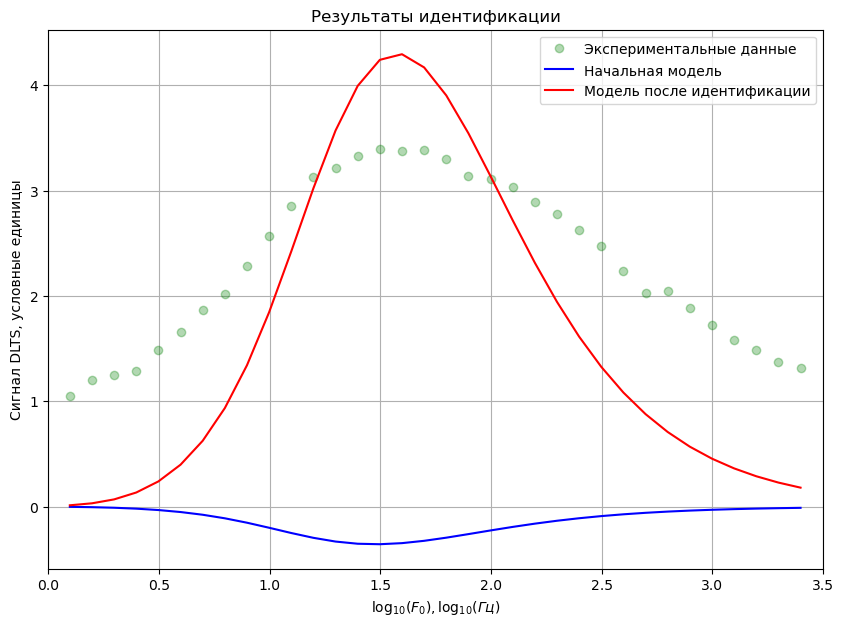

In [24]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, multiexp_fs.fit_results_, plot_exps=False)
plt.show()

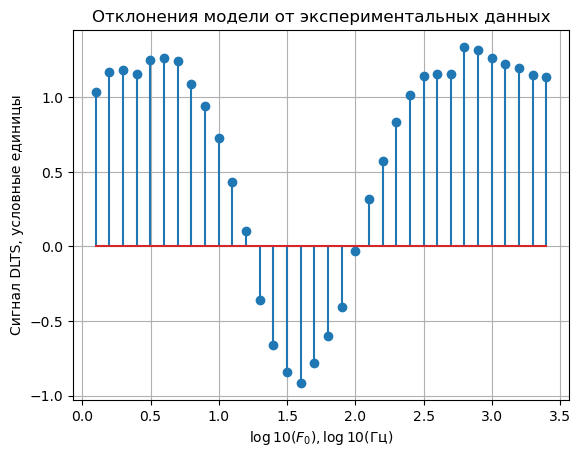

In [25]:
plot_deviations(X_train, y_train, multiexp_fs.predict(X_train))
plt.show()

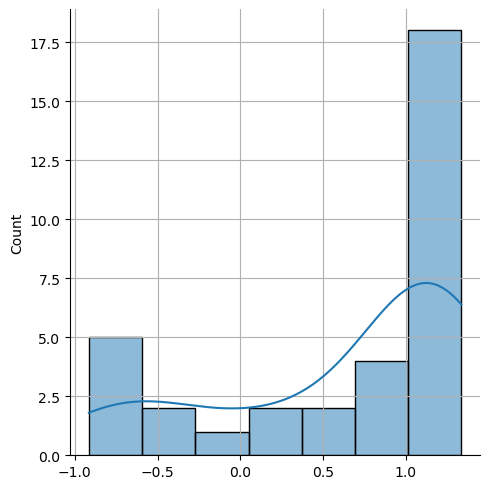

In [26]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=7, kde=True)
plt.grid()
plt.show()

In [27]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [28]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [1.42492329 2.55668243 1.46125152]
Mean: 1.8142857478560437
Standard deviation: 0.5251631911156343


In [29]:
mean_squared_error(y_train, multiexp_fs.predict(X_train), squared=False)

0.9805111759141903

### 2.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [30]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [31]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=3, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [32]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [33]:
grid_search.best_params_

{'n_exps': 9}

In [34]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

2.3204152123043666 {'n_exps': 1}
1.2435039911277341 {'n_exps': 2}
0.897781831126687 {'n_exps': 3}
0.5913962060108506 {'n_exps': 4}
0.5508967506013503 {'n_exps': 5}
0.624255902391854 {'n_exps': 6}
0.5388256568808709 {'n_exps': 7}
0.5731951711258421 {'n_exps': 8}
0.485734898971279 {'n_exps': 9}
0.5810990262536964 {'n_exps': 10}


In [35]:
y_pred = grid_search.best_estimator_.predict(X_train)

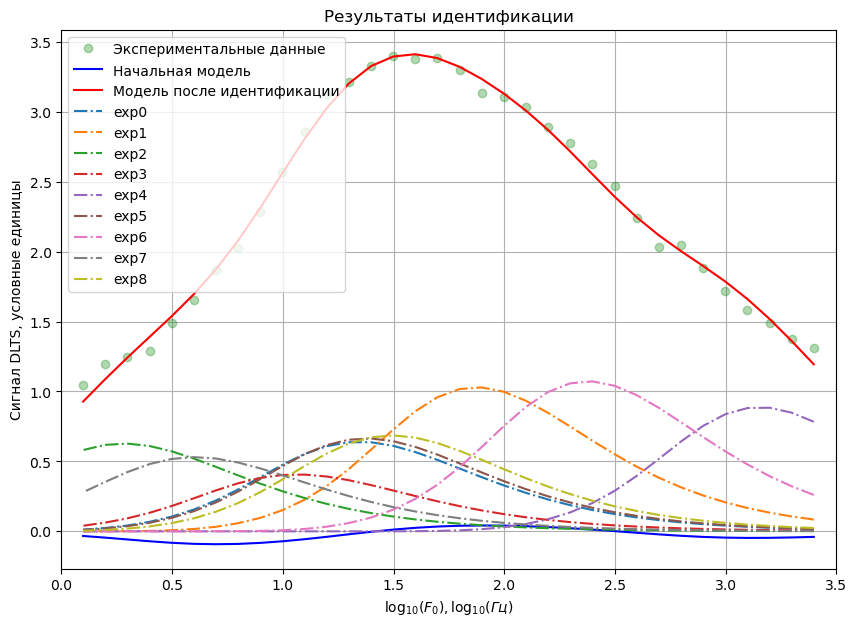

In [37]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, grid_search.best_estimator_.fit_results_)

plt.show()

In [38]:
grid_search.best_estimator_.fit_results_

,amplitude_0,amplitude_1,amplitude_2,amplitude_3,amplitude_4,amplitude_5,amplitude_6,amplitude_7,amplitude_8,filling_pulse,...,time_constant_pow_0,time_constant_pow_1,time_constant_pow_2,time_constant_pow_3,time_constant_pow_4,time_constant_pow_5,time_constant_pow_6,time_constant_pow_7,time_constant_pow_8,verbose
0,0.052291,0.059157,-0.084058,-0.100894,-0.055794,0.058877,0.014509,0.000296,-0.030169,0.00001,...,-1.372346,-2.028649,-1.086193,-1.335111,-3.418256,-1.386901,-2.458825,-1.220781,-1.538566,False
1,0.153793,0.172764,0.002190,-0.001126,-0.004818,0.161033,0.116632,0.094233,0.077901,0.00001,...,-1.374718,-2.027995,-1.081154,-1.330298,-3.421702,-1.389515,-2.458243,-1.220797,-1.537567,False
2,0.236942,0.270639,0.071670,0.080116,0.042359,0.244799,0.207469,0.170499,0.167305,0.00001,...,-1.381184,-2.027723,-1.081264,-1.330249,-3.421973,-1.396191,-2.454784,-1.225224,-1.540234,False
3,0.305080,0.355236,0.127637,0.146249,0.086363,0.313520,0.288709,0.232395,0.241326,0.00001,...,-1.390403,-2.029339,-1.084234,-1.333433,-3.419799,-1.405644,-2.450459,-1.232181,-1.546012,False
4,0.360895,0.428524,0.172655,0.200015,0.127651,0.369883,0.361593,0.282546,0.302636,0.00001,...,-1.401364,-2.033532,-1.088576,-1.338687,-3.415737,-1.416892,-2.446589,-1.240397,-1.554261,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.640128,1.030421,0.627216,0.406613,0.888419,0.664062,1.072767,0.530886,0.685686,0.00001,...,-1.702139,-2.229436,-0.637239,-1.418250,-3.523717,-1.732819,-2.733742,-0.958803,-1.848932,False
298,0.640235,1.030422,0.627361,0.406628,0.888310,0.664169,1.072926,0.530801,0.685772,0.00001,...,-1.702144,-2.229501,-0.636779,-1.418478,-3.523921,-1.732776,-2.733850,-0.958563,-1.848743,False
299,0.640342,1.030424,0.627506,0.406642,0.888199,0.664275,1.073084,0.530715,0.685857,0.00001,...,-1.702147,-2.229567,-0.636321,-1.418705,-3.524123,-1.732733,-2.733957,-0.958325,-1.848555,False
300,0.640449,1.030425,0.627649,0.406657,0.888088,0.664381,1.073242,0.530630,0.685942,0.00001,...,-1.702151,-2.229634,-0.635866,-1.418932,-3.524325,-1.732689,-2.734064,-0.958088,-1.848367,False


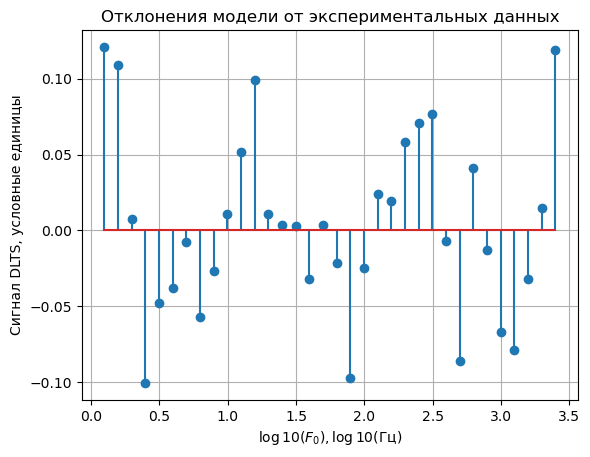

In [39]:
plot_deviations(X_train, y_train, y_pred)
plt.show()

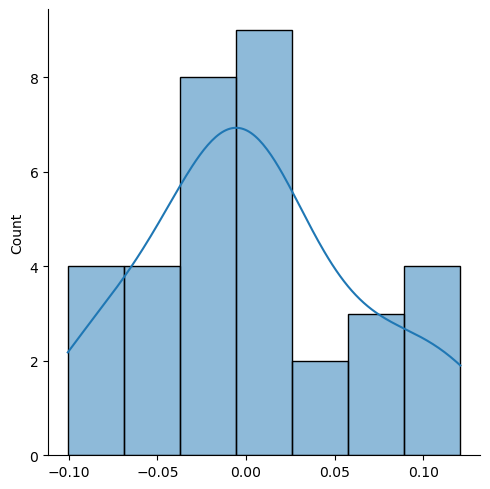

In [40]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

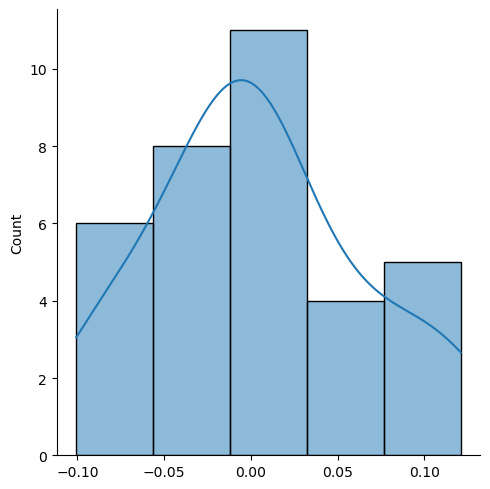

In [41]:
sns.displot(x=y_train - y_pred, bins=5, kde=True)
plt.show()

In [42]:
exps_params_303 = grid_search.best_estimator_.exps_params_
exps_params_303[:, 1] = exps_params_303[:, 1] / k

## 3. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_+10С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,01.csv
### 3.1. Подготовка экспериментальных данных

In [62]:
filling_pulse, X_train, y_train = get_X_y(data_frames[1][1])

In [63]:
k, y_train = normalize(X_train, y_train)
k

835.2851545408156

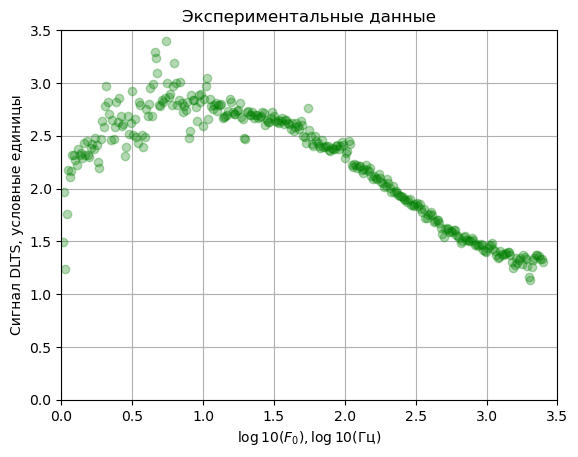

In [64]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_ylim([0, 3.5])
ax.set_xlim([0, 3.5])
plt.show()

### 3.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [65]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)
monoexp_fs.fit_results_

,amplitude_0,filling_pulse,fit_p_coef,learning_rate,loss,n_exps,n_iters,p_coef,stop_val,time_constant_pow_0,verbose
0,-0.281940,0.00001,True,0.05,5.880868,1,1000,1.000000,0.00001,-1.337029,False
1,-0.172445,0.00001,True,0.05,5.641851,1,1000,1.014184,0.00001,-1.336857,False
2,-0.066557,0.00001,True,0.05,5.420018,1,1000,1.022572,0.00001,-1.336772,False
3,0.036149,0.00001,True,0.05,5.211908,1,1000,1.025726,0.00001,-1.336744,False
4,0.136027,0.00001,True,0.05,5.014786,1,1000,1.024046,0.00001,-1.336758,False
...,...,...,...,...,...,...,...,...,...,...,...
135,2.877388,0.00001,True,0.05,0.018108,1,1000,0.172537,0.00001,-1.262336,False
136,2.878155,0.00001,True,0.05,0.018096,1,1000,0.172664,0.00001,-1.262444,False
137,2.878897,0.00001,True,0.05,0.018085,1,1000,0.172788,0.00001,-1.262550,False
138,2.879614,0.00001,True,0.05,0.018074,1,1000,0.172907,0.00001,-1.262655,False


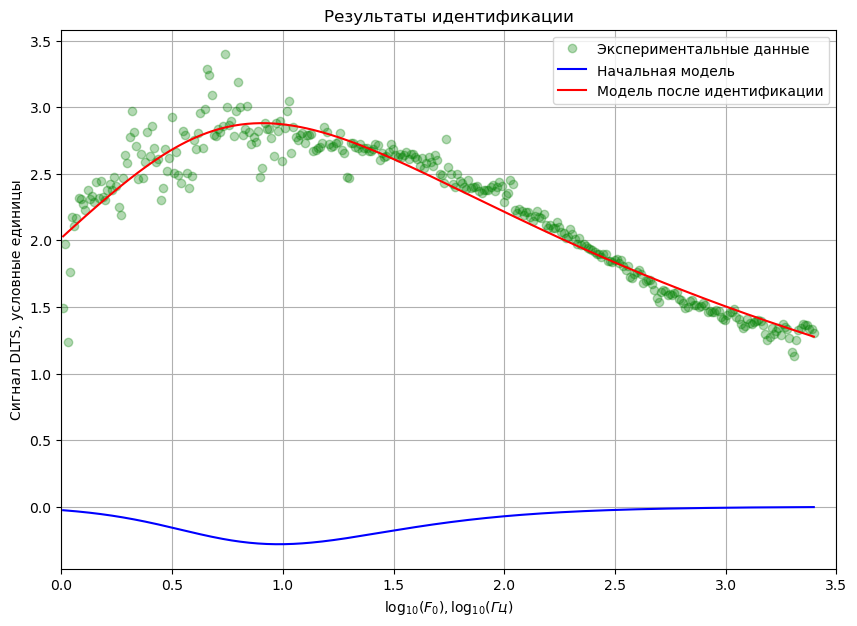

In [66]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, monoexp_fs.fit_results_, plot_exps=False)
plt.show()

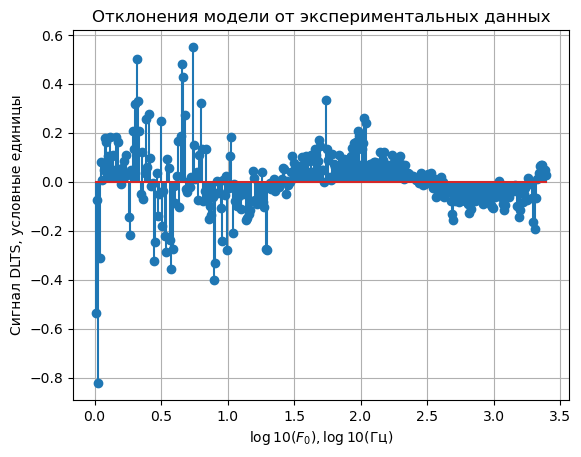

In [67]:
plot_deviations(X_train, y_train, monoexp_fs.predict(X_train))
plt.show()

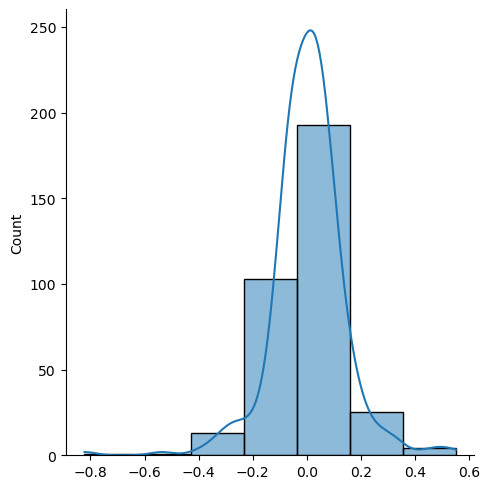

In [68]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

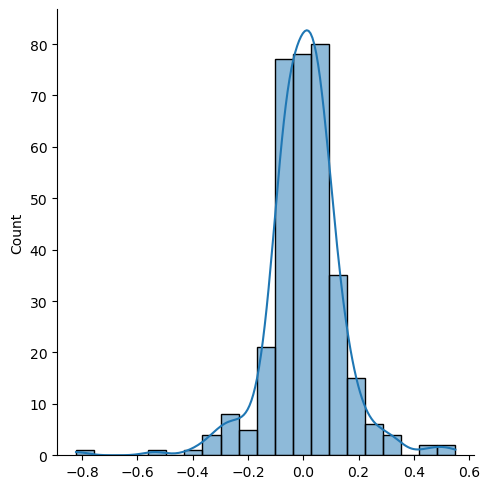

In [69]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=21, kde=True)
plt.show()

In [70]:
mean_squared_error(y_train, y_train - monoexp_fs.predict(X_train), squared=False)

2.2864173799107994

### 3.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [71]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       stop_val = 10**-5,
                                       learning_rate=0.05,
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                         learning_rate=0.05, stop_val=1e-05)

In [72]:
multiexp_fs.fit_results_

,amplitude_0,filling_pulse,learning_rate,loss,n_exps,n_iters,stop_val,time_constant_pow_0,verbose
0,-0.755445,0.00001,0.05,6.748539,1,1000,0.00001,-2.196631,False
1,-0.648586,0.00001,0.05,6.514456,1,1000,0.00001,-2.219165,False
2,-0.545220,0.00001,0.05,6.297097,1,1000,0.00001,-2.238811,False
3,-0.445173,0.00001,0.05,6.094988,1,1000,0.00001,-2.255539,False
4,-0.348275,0.00001,0.05,5.906706,1,1000,0.00001,-2.269342,False
...,...,...,...,...,...,...,...,...,...
195,3.831271,0.00001,0.05,1.345594,1,1000,0.00001,-1.340013,False
196,3.832035,0.00001,0.05,1.345583,1,1000,0.00001,-1.340011,False
197,3.832779,0.00001,0.05,1.345572,1,1000,0.00001,-1.340010,False
198,3.833503,0.00001,0.05,1.345561,1,1000,0.00001,-1.340009,False


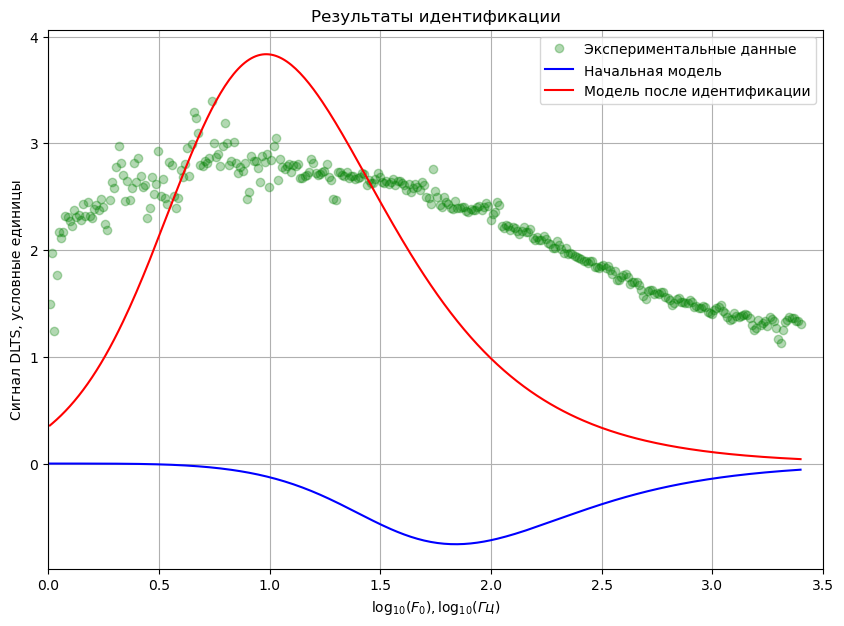

In [73]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, multiexp_fs.fit_results_, plot_exps=False)
plt.show()

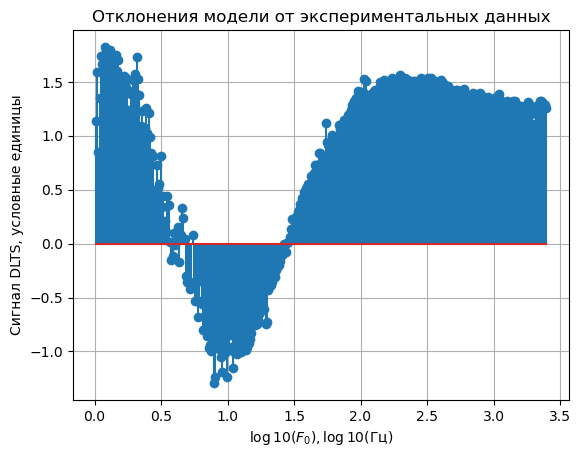

In [74]:
plot_deviations(X_train, y_train, multiexp_fs.predict(X_train))
plt.show()

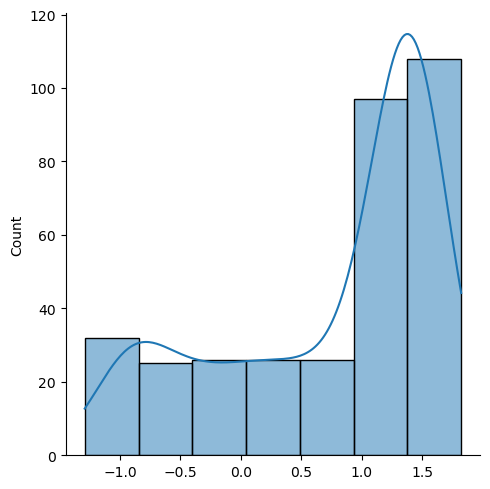

In [75]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

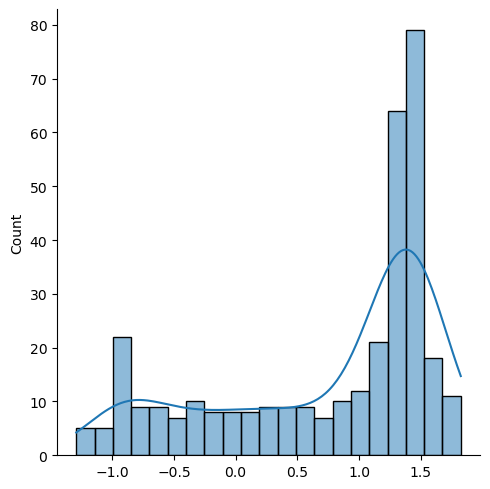

In [76]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=21, kde=True)
plt.show()

In [77]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [1.42341937 2.14389165 2.36581827]
Mean: 1.977709766278464
Standard deviation: 0.40227787788563246


In [79]:
mean_squared_error(y_train, multiexp_fs.predict(X_train), squared=False)

1.1599791170984823

### 3.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [80]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [81]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=3, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_train)

In [ ]:
fig, ax = plot_model(X_train, y_train, grid_search.best_estimator_.fit_results_)

plt.show()

In [ ]:
grid_search.best_estimator_.fit_results_

In [ ]:
plot_deviations(X_train, y_train, y_pred)
plt.show()

In [ ]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

In [ ]:
sns.displot(x=y_train - y_pred, bins=21, kde=True)
plt.show()

In [ ]:
exps_params_283 = grid_search.best_estimator_.exps_params_
exps_params_283[:, 1] = exps_params_303[:, 1] / k

In [ ]:
mean_squared_error(y_train, y_pred, squared=False)

## 4. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_-10С\_-4В-5В\_10мВ\_10мкс\_шаг\_0,01.csv
### 4.1. Подготовка экспериментальных данных

In [ ]:
filling_pulse, X_train, y_train = get_X_y(data_frames[2][1])

In [ ]:
k, y_train = normalize(X_train, y_train)
k

In [ ]:
fig, ax = plot_experimental_points(X_train, y_train)
ax.set_ylim([0, 3.5])
ax.set_xlim([0, 3.5])
plt.show()

### 4.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [ ]:
monoexp_fs = SklSingleExpFrequencyScan(filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5,
                                       verbose = False
                                      )

monoexp_fs.fit(X = X_train, y = y_train)
monoexp_fs.fit_results_

In [ ]:
fig, ax = plot_model(X_train, y_train, SklSingleExpFrequencyScan, monoexp_fs.fit_results_, plot_exps=False)
plt.show()

In [ ]:
plot_deviations(X_train, y_train, monoexp_fs.predict(X_train))
plt.show()

In [ ]:
sns.displot(x=y_train - monoexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

In [ ]:
mean_squared_error(y_train, y_train - monoexp_fs.predict(X_train), squared=False)

### 4.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [ ]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       stop_val = 10**-5,
                                       learning_rate=0.05,
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

In [ ]:
multiexp_fs.fit_results_

In [ ]:
fig, ax = plot_model(X_train, y_train, SklMultiExpFrequencyScan, multiexp_fs.fit_results_, plot_exps=False)
plt.show()

In [ ]:
plot_deviations(X_train, y_train, multiexp_fs.predict(X_train))
plt.show()

In [ ]:
sns.displot(x=y_train - multiexp_fs.predict(X_train), bins=7, kde=True)
plt.show()

In [ ]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
display_scores(np.sqrt(-scores))

In [ ]:
mean_squared_error(y_train, multiexp_fs.predict(X_train), squared=False)

### 4.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [ ]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [ ]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=3, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_train)

In [ ]:
fig, ax = plot_model(X_train, y_train, grid_search.best_estimator_.fit_results_)
plt.show()

In [ ]:
grid_search.best_estimator_.fit_results_

In [ ]:
plot_deviations(X_train, y_train, y_pred)
plt.show()

In [ ]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

In [ ]:
sns.displot(x=y_train - y_pred, bins=5, kde=True)
plt.show()

In [ ]:
exps_params_303 = grid_search.best_estimator_.exps_params_
exps_params_303[:, 1] = exps_params_303[:, 1] / k